# This is a notebook about predicting aurora

# 0. Data Downloading

In [59]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [60]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [61]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Exploration
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [62]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

,Datetime,Kp_Index,Status
0,1932-01-01 00:00:00+00:00,3.333,def
1,1932-01-01 03:00:00+00:00,2.667,def
2,1932-01-01 06:00:00+00:00,2.333,def
3,1932-01-01 09:00:00+00:00,2.667,def
4,1932-01-01 12:00:00+00:00,3.333,def


In [63]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270864 entries, 0 to 270863
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270864 non-null  datetime64[ns, UTC]
 1   Kp_Index  270864 non-null  float64            
 2   Status    270864 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [64]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

In [84]:
# Let's define a function for plotting the Kp index over a specified date range. 

def plot_kp_index_by_date_range(kpindex_data, start_date=None, end_date=None):
    """
    Function to filter Kp index data by a specific date range, plot the data, and highlight the highest point.
    
    Parameters:
    kpindex_data (pd.DataFrame): The full Kp index dataset containing 'Datetime' and 'Kp_Index'.
    start_date (str, optional): The start date (inclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    end_date (str, optional): The end date (exclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    
    Returns:
    None
    """

    # Ensure 'Datetime' is in datetime format
    kpindex_data['Datetime'] = pd.to_datetime(kpindex_data['Datetime'])
    
    # Filter the data for the given date range
    if start_date and end_date:
        filtered_data = kpindex_data[(kpindex_data['Datetime'] >= start_date) & 
                                     (kpindex_data['Datetime'] < end_date)]
    else:
        filtered_data = kpindex_data

    # Check if data exists in the date range
    if filtered_data.empty:
        print("No data available for the specified date range.")
        return
    
    # Find the highest Kp index value and its corresponding time
    peak_kp_value = filtered_data['Kp_Index'].max()
    peak_kp_time = filtered_data[filtered_data['Kp_Index'] == peak_kp_value]['Datetime'].values[0]
    
    # Plot the filtered data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['Datetime'], filtered_data['Kp_Index'], label="Kp Index", color='blue')

    # Highlight the peak
    plt.scatter(peak_kp_time, peak_kp_value, color='red', zorder=5, label=f'Peak Kp Index ({pd.to_datetime(peak_kp_time).strftime("%Y-%m-%d")} UTC)')

    # Annotate the peak value
    plt.text(peak_kp_time, peak_kp_value + 0.2, f"Peak: {peak_kp_value:.1f}", color='red')

    # Labels and title
    if start_date and end_date:
        title = f'Kp Index from {start_date} to {end_date} (Highlighted Peak)'
    else:
        title = 'Kp Index (Highlighted Peak for All Data)'
    
    plt.xlabel('Date')
    plt.ylabel('Kp Index')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()


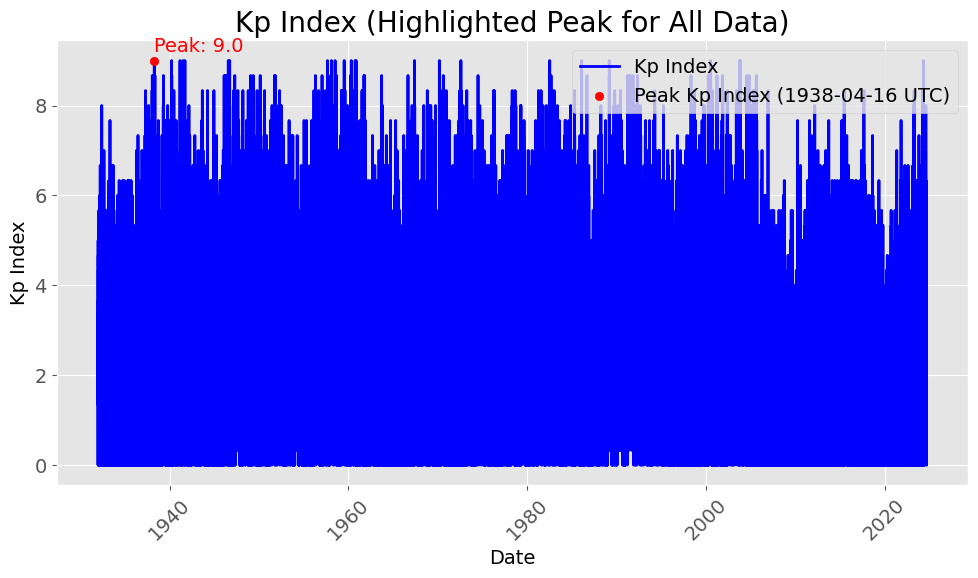

In [85]:
# To show all data:
plot_kp_index_by_date_range(kpindex_df)

This is a very large plot with many years of data. There doesn't seem to be an increase or decrease in Kp index over the long timeframe, as suggested by the flat trend. 

As I intended to forecast aurora presence per day, I'm going to take the 24 hours mean. 

Let's look at the past year's data (2023).

In [86]:
# Create a new column for the date only (ignore the time part)
kpindex_df['Date'] = kpindex_df['Datetime'].dt.date

# Group by the 'Date' column and calculate the mean Kp index per day
daily_mean_df = kpindex_df.groupby('Date').agg(Daily_Kp_Max=('Kp_Index', 'max')).reset_index()

daily_mean_df = pd.DataFrame(daily_mean_df)

daily_mean_df = daily_mean_df.rename(columns={"Date": "Datetime", "Daily_Kp_Max": "Kp_Index"})

daily_mean_df.head()

,Datetime,Kp_Index
0,1932-01-01,3.333
1,1932-01-02,5.000
2,1932-01-03,3.333
3,1932-01-04,2.000
4,1932-01-05,2.000


Let's plot all data again. Hopefully this is clearer. 

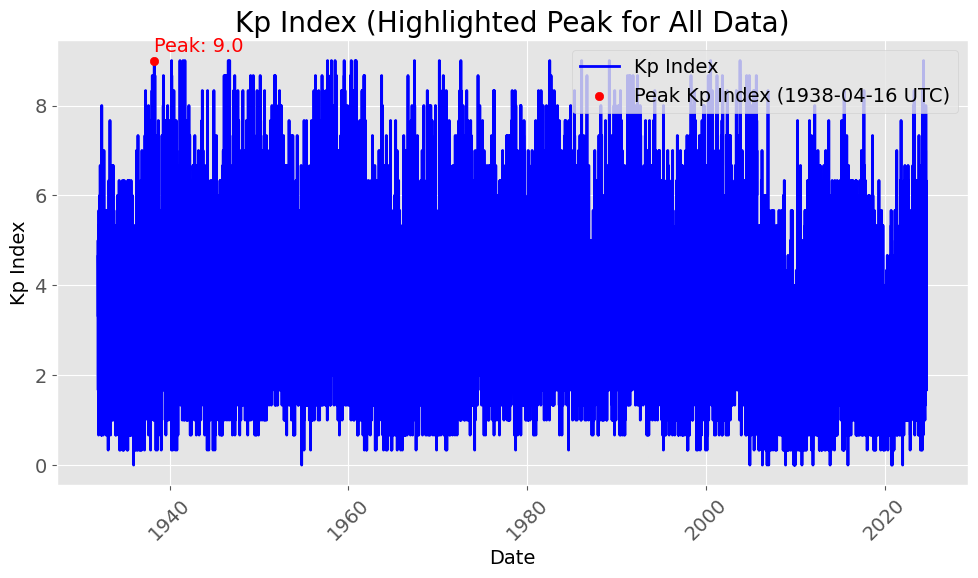

In [87]:
# To show all data:
plot_kp_index_by_date_range(daily_mean_df)

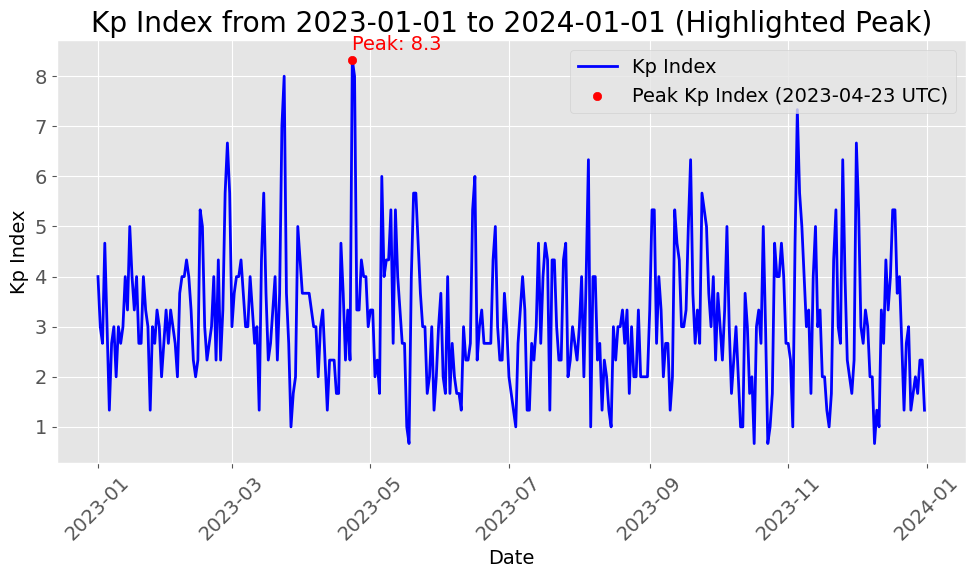

In [88]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2023-01-01', '2024-01-01')

There are ups and downs in the Kp Index but overall there isn't a upward or downward trend. 

Let's look at the past month only (August 2024). 

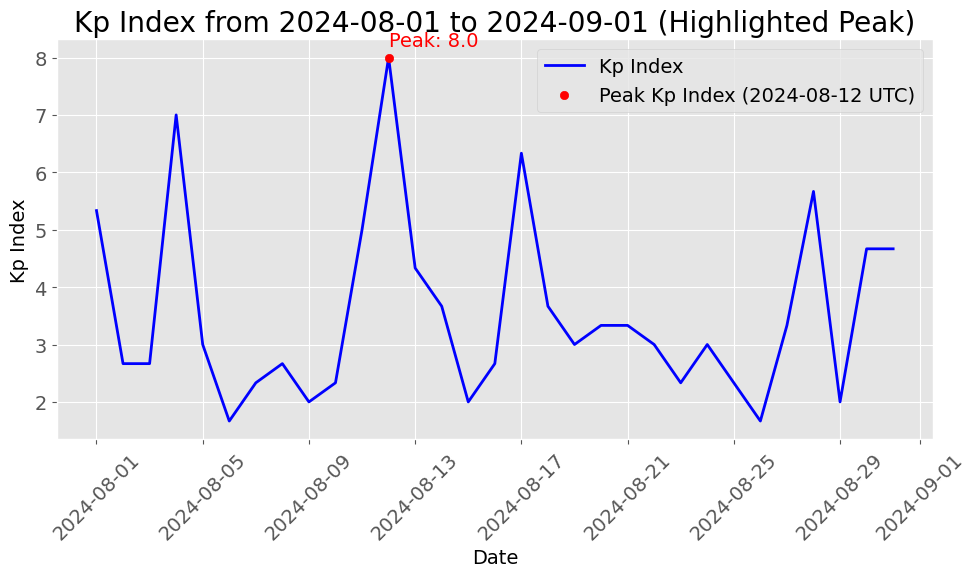

In [89]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-08-01', '2024-09-01')

Looks like there are variations of different widths. I personally was able to see aurora borealis on August 12th, 2024, which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

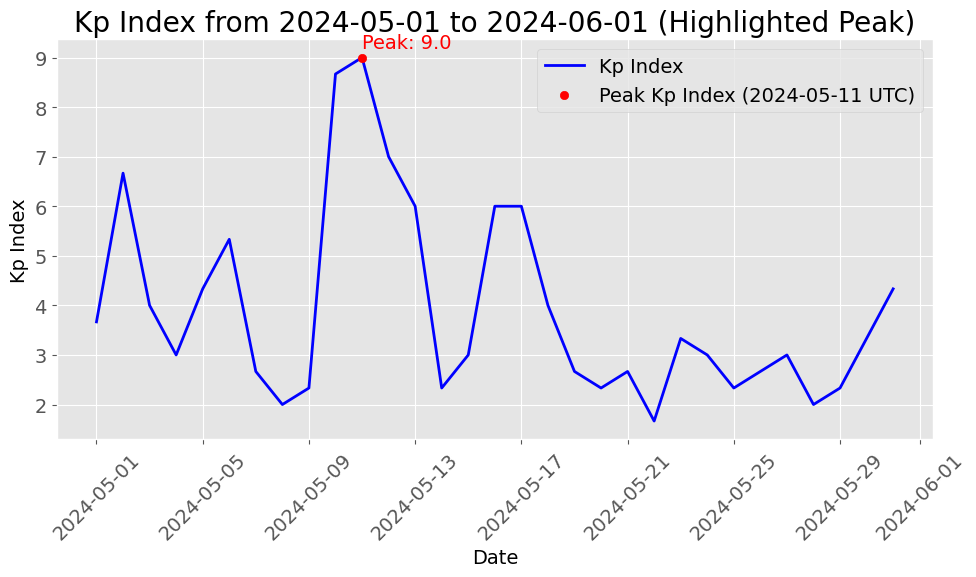

In [91]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-05-01', '2024-06-01')

What about in September 2024?

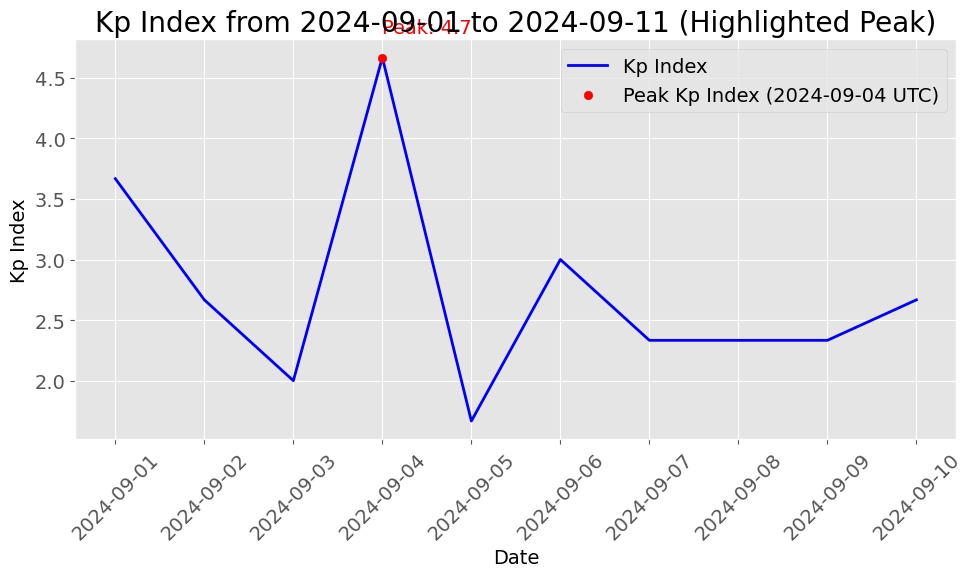

In [92]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_mean_df, '2024-09-01', '2024-09-11')

## 1.2 Autocorrelation (Trends)
With a lot of time-series data, there are temporal dependence, which means the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Firstly, let's examine if there are trends over the years. I'm going to try the polynomila orders 0, 1, and 3 to capture the trend.

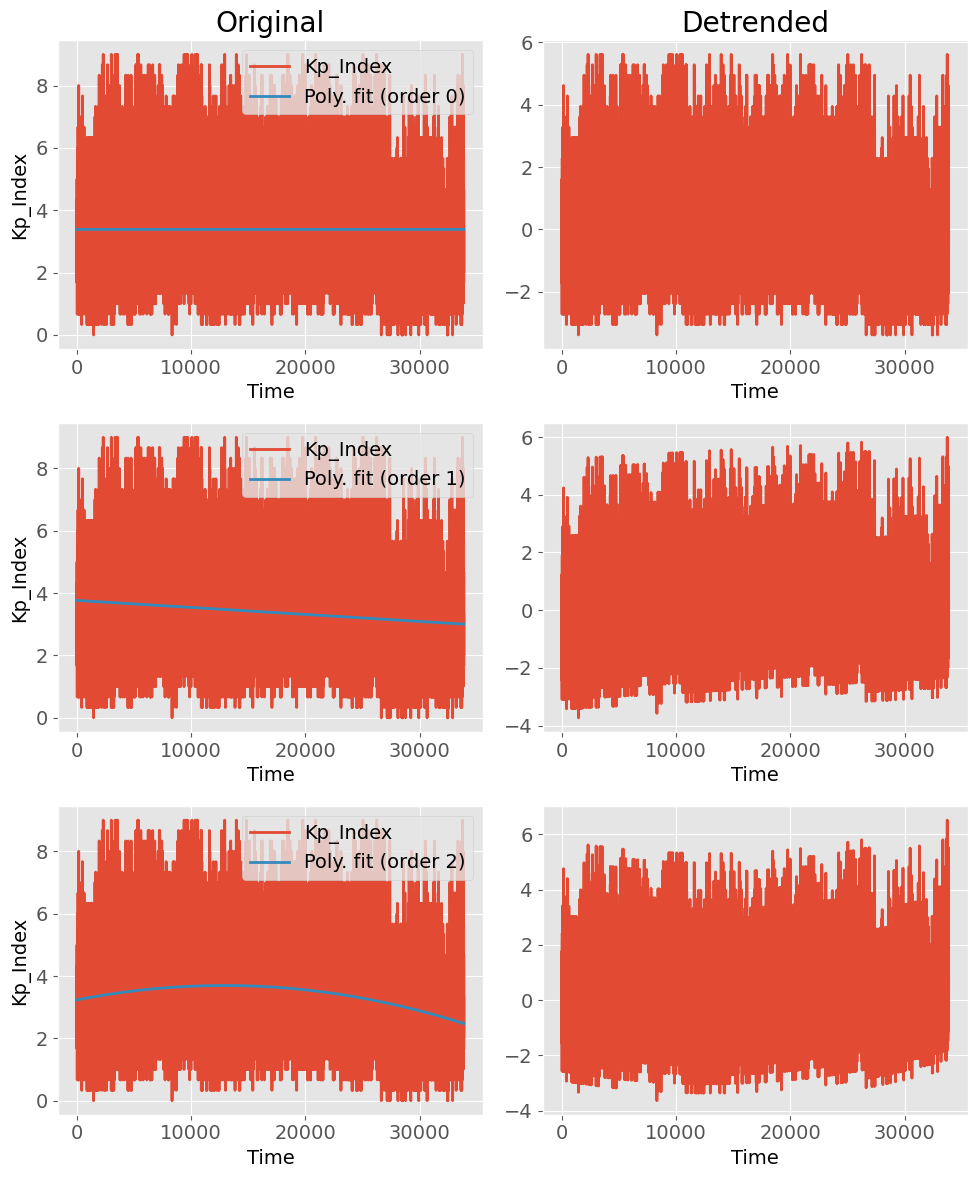

In [93]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for order in range(3):
    fit_label = f"Poly. fit (order {order})"
    daily_mean_df[fit_label] = daily_mean_df["Kp_Index"] - detrend(daily_mean_df["Kp_Index"], order=order)
    daily_mean_df[["Kp_Index", fit_label]].plot.line(xlabel="Time", ylabel="Kp_Index", ax=axes[order, 0])
    (daily_mean_df["Kp_Index"] - daily_mean_df[fit_label]).plot.line(xlabel="Time", legend=False, ax=axes[order, 1])
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Detrended")
plt.tight_layout();

Looks like the polynomial fit of order 0 had the better looking detrended data. I guess the data over the entire period of time isn't increaseing or decreasing. 

## 1.3 Seasonality

Text(0, 0.5, 'ACF')

<Figure size 2000x600 with 0 Axes>

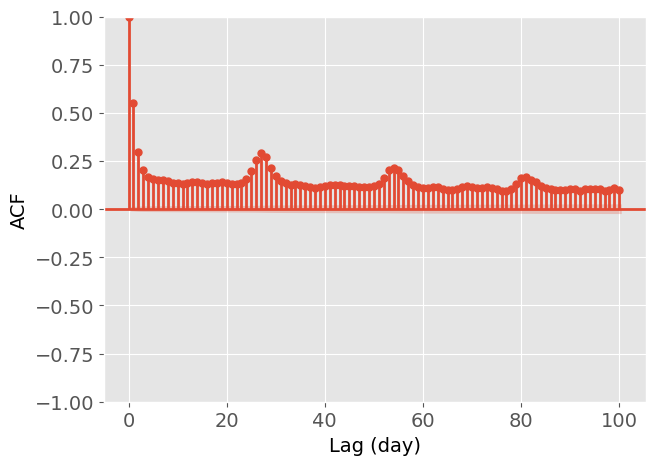

In [97]:
plt.figure(figsize=(20, 6))
acf_fig = plot_acf(daily_mean_df["Kp_Index"], lags=100, title=None, bartlett_confint=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

There seems to be a trend of autocorrelation around every 25-30 lags. Maybe this is the cycle of the moon? 

Let me first get the exact lag value. 

In [100]:
acf_data = acf(daily_mean_df["Kp_Index"], nlags=100, bartlett_confint=True)
acf_data[:25]

array([1.        , 0.55385213, 0.29637054, 0.20331424, 0.16512549,
       0.15647265, 0.15298494, 0.15109498, 0.14411544, 0.13813242,
       0.13421892, 0.1329623 , 0.13710953, 0.14350588, 0.14048875,
       0.13608723, 0.1318445 , 0.13541181, 0.13843711, 0.13916695,
       0.13711424, 0.13040241, 0.13130579, 0.13689943, 0.15558463])

In [101]:
# Create lags array
lags = np.arange(len(acf_data))

# Define the range for finding the highest point
start_lag = 20
end_lag = 40

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 27 with a value of 0.291292066319797.


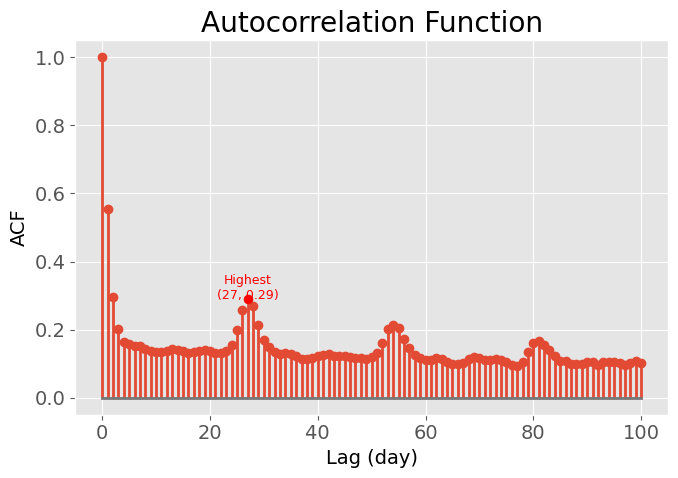

In [102]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

So there seems to be the autocorrelation at 27 days. 

Let's use `STL` to remove this seasonality. This is a more advanced method of decomposition which uses LOESS (locally estimated scatterplot smoothing).

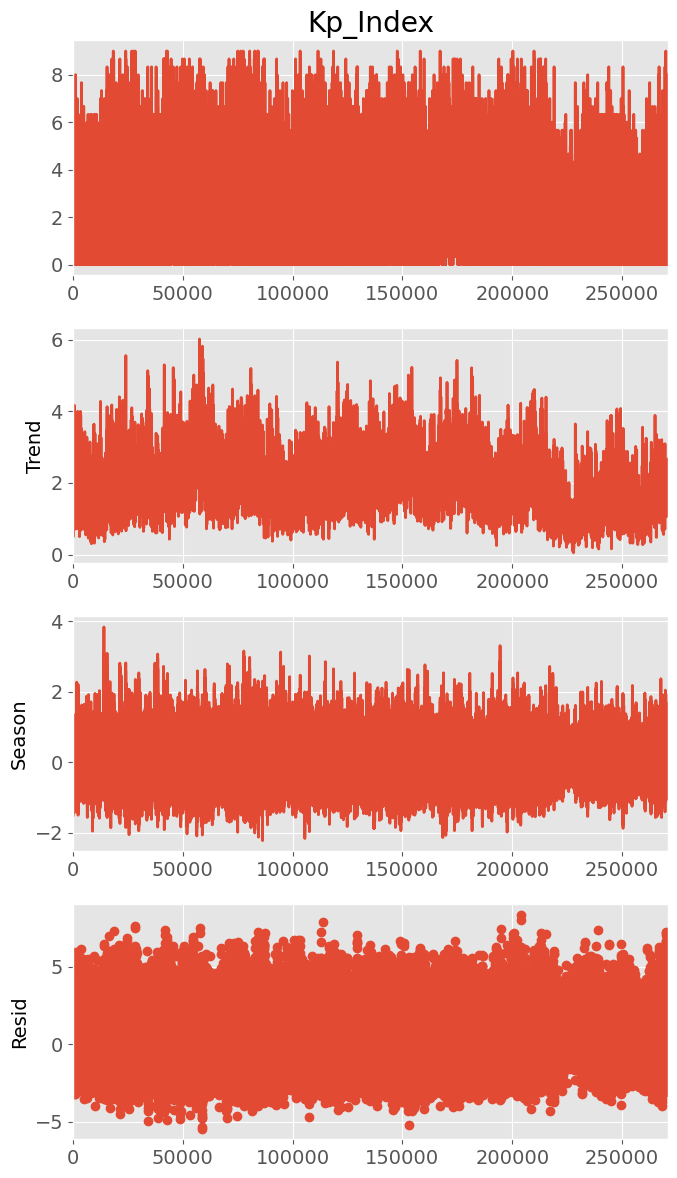

In [103]:
from statsmodels.tsa.seasonal import STL
model = STL(kpindex_df["Kp_Index"], period=27, trend=55, robust=True).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(7, 12))
    model.plot()

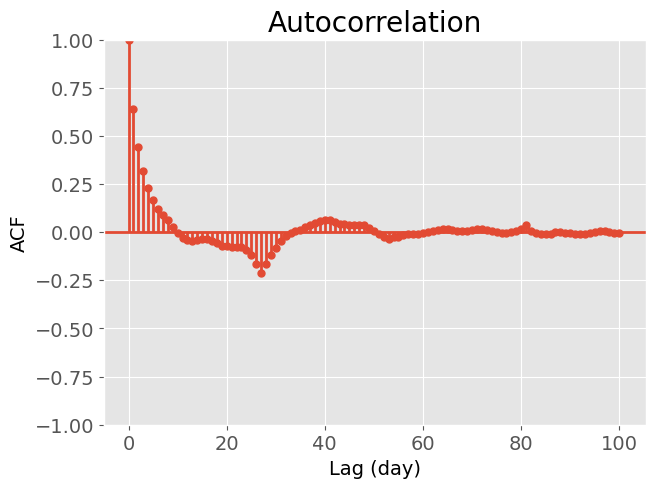

In [105]:
fig = plot_acf(model.resid, lags=100)
plt.ylabel("ACF")
plt.xlabel("Lag (day)");

The detrended data looks much better. Although there are still some repeats at lag 27, but the ones after are removed. 

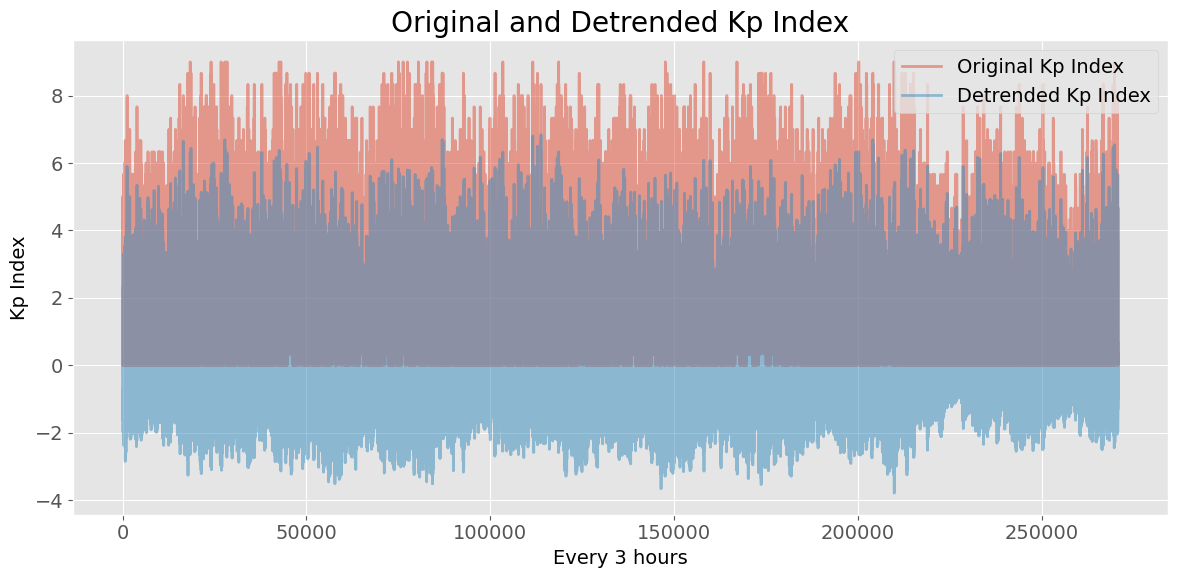

In [35]:
# Plot the original and detrended data for comparison
plt.figure(figsize=(12, 6))
plt.plot(daily_mean_df.index, kpindex_df["Kp_Index"], label="Original Kp Index", alpha=0.5)
plt.plot(daily_mean_df.index, daily_mean_df["Detrended_Kp_Index"], label="Detrended Kp Index", alpha=0.5)
plt.xlabel("Every 3 hours")
plt.ylabel("Kp Index")
plt.title("Original and Detrended Kp Index")
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineering

To improve your forecast accuracy, we can add additional features. For example:

Rolling average of the Kp index to smooth short-term fluctuations.
Lag features (previous Kp values) to capture temporal relationships.

In [18]:
# # Add rolling average for Kp_Index (e.g., 24 hours)
# kpindex_df['Kp_24h_avg'] = kpindex_df['Kp_Index'].rolling(window=8).mean()

# # Add lag feature (Kp value from 3 hours ago)
# kpindex_df['Kp_lag_3h'] = kpindex_df['Kp_Index'].shift(1)

# # Drop any rows with NaN values created by rolling or lag features
# kpindex_df.dropna(inplace=True)

# # Check the new features
# kpindex_df.head()


Train-Test Split
Before you build a model, split the data into a training set (for model training) and a test set (to evaluate model performance).

In [19]:
# from sklearn.model_selection import train_test_split

# # Train-test split (e.g., 80% train, 20% test)
# train_df, test_df = train_test_split(kpindex_df, test_size=0.2, shuffle=False)

# # Verify the split
# print(f"Training data length: {len(train_df)}")
# print(f"Test data length: {len(test_df)}")